In [1]:
# needed while on test instance
import os
import h5py
import numpy as np
import cdsapi

# Set the API credentials as environment variables
os.environ['CDSAPI_URL'] = 'https://cds-test-cci2.copernicus-climate.eu/api'
os.environ['CDSAPI_KEY'] = 'df82e606-b379-4e83-b4a3-c578ca99ab8c'
print(os.getcwd())

/srvfs/home/leo/python/CEUAS/CEUAS/public/testing


Hi Markel,
the cell above and the following three cells should reproduce the problem with the alignment of bias adjustment values for specific humidity. Similar problems occur with windspeed and direction. 
In the cell below you see commented #area. The current one is for the station in Kazachstan (35229), the other one is for Vienna (11035).
The one from Kazachstan has the problem (observation values are ok but not the adjustments), while Vienna seems ok for both observation values and adjustments. Those are printed together with date and observation values for the first few values. If there are strange values (>0.1) those are printed separately. Interestingly they appear to be at the first of the months.  

In the third cell I retrieved and plotted the data directly from the file that can be found on the VM in the directory converted_v29. You need to download that locally for the cell to work. As you can see the adjustments look very different for 35229 but are fine for 11035.

In [2]:
dataset = "insitu-comprehensive-upper-air-observation-network"
request = {
    "variable": [
        "air_dewpoint",
        "air_temperature",
        "dew_point_depression",
        "eastward_wind_speed",
        "geopotential_height",
        "northward_wind_speed",
        "relative_humidity",
        "specific_humidity",
        "wind_from_direction",
        "wind_speed"
    ],
    'year': [f'{m}' for m in range(1975,1976)],
    'month': [f'{m:0>2}' for m in range(1,13)],
    'day': ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31'],
    "data_format": "netcdf",
    "area": [51, 55, 50, 58]
}
#"area": [51, 55, 50, 58] # use for station 0-20000-0-35229
#    "area": [49, 15, 48, 18] # use for station 0-20001-0-11035

target='newts2.nc'
client = cdsapi.Client()
client.retrieve(dataset, request,target)

2025-06-12 14:51:35,092 INFO [2025-06-10T00:00:00] To improve our C3S service, we need to hear from you! Please complete this very short [survey](https://confluence.ecmwf.int/x/E7uBEQ/). Thank you.
2025-06-12 14:51:35,093 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-06-12 14:51:35,640 INFO Request ID is 93ccb976-91dd-457d-9d09-d7ccba535a8b
2025-06-12 14:51:35,746 INFO status has been updated to running
2025-06-12 14:51:36,877 INFO status has been updated to successful


11c71e933b688e819eb6a4302619ed75.nc:   0%|          | 0.00/7.74M [00:00<?, ?B/s]

'newts2.nc'

/srvfs/home/leo/python/CEUAS/CEUAS/public/testing
b'0-20000-0-35229'
[57.15    57.22    57.22361]
[b'0-20000-0-35229']
[b'air_dewpoint' b'air_temperature' b'dew_point_depression'
 b'eastward_wind_speed' b'geopotential_height' b'northward_wind_speed'
 b'relative_humidity' b'specific_humidity' b'wind_from_direction'
 b'wind_speed']
(13795,) (10,) 2366776800
b'specific_humidity' 14,325,314 0.043796759098768234 0.37799668312072754
1975-01-01 12:00:00 nan 7.147219e-05
1975-01-02 12:00:00 4.4199905e-06 2.0428159e-05
1975-01-03 12:00:00 0.0 3.19997e-05
1975-01-04 12:00:00 6.160037e-06 9.333831e-05
1975-01-05 12:00:00 0.0 3.165079e-05
1975-01-06 12:00:00 4.123207e-05 2.1651662e-05
1975-01-07 12:00:00 1.4121641e-05 2.1271951e-05
1975-01-08 12:00:00 0.0 8.578621e-05
1975-01-09 12:00:00 5.0109873e-13 3.0695945e-05
1975-01-10 12:00:00 -5.965603e-06 4.7913825e-05
[2371896000 2377166400 2382436800 2390385600 2393064000 2395656000]
SPURIOUS 1975-03-01 12:00:00 2.3950634 b'specific_humidity' 1.0434164

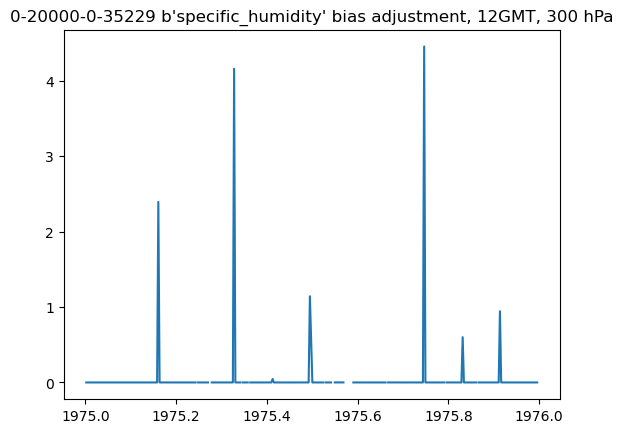

In [3]:
import matplotlib.pyplot as plt
from datetime import datetime,timedelta
print(os.getcwd())
pl=300
with h5py.File('newts2.nc') as f:
    #print(f.keys())
    wigos=f['primary_station_id'][:].view(f'S{f['primary_station_id'].shape[1]}').flatten()
    wu=np.unique(wigos)[0]
    print(wu)#,f['z_coordinate'][:100])
    print(np.unique(f['longitude|header_table'][:]))
    idx=np.where((f['z_coordinate'][:]==pl*100)&(wigos==wu))[0] #(wigos==b'0-20001-0-11035')&
    print(np.unique(wigos[idx]))
    vnames=(f['observed_variable'][:].view(f'S{f['observed_variable'].shape[1]}').flatten())[idx]
    #print(idx)
    vnu,vni=np.unique(vnames,return_inverse=True)
    print(vnu)
    ha=f["homogenisation_adjustment"][:][idx]
    obs=f["observation_value"][:][idx]
    ts=f["record_timestamp"][:][idx]
    print(vni.shape,vnu.shape,ts[0])
    l=1
    for v in [b'specific_humidity']: #vnu[1:]:
#        #print(np.unique(vnames[idx]),f['report_timestamp'][:2])
        idy=np.where((vnames==v)&(ts%86400==43200)&(~np.isnan(obs)))[0]
        if len(idy)>0:
             print(f'{v} {idy[0]},{len(idy)},{np.sum(~np.isnan(ha[idy]))} {np.nanmean(ha[idy])} {np.nanstd(ha[idy])}')
        l+=1
        for i in idy[:10]:
            print(datetime(1900,1,1)+timedelta(seconds=int(ts[i])),ha[i],obs[i])
        if v==b'specific_humidity':
            idz=np.where(np.abs(ha[idy])>0.1)[0]
            tsh=ts[idy[idz]]
            print(tsh)
            for ind in idz:
                print('SPURIOUS',datetime(1900,1,1)+timedelta(seconds=int(ts[idy[ind]])),ha[idy[ind]],vnames[idy[ind]],obs[idy[ind]])
        plt.plot(ts[idy]/86400/365.25+1900,ha[idy])
        plt.title(wigos[0].decode()+f' {v} bias adjustment, 12GMT, {pl} hPa')
        #plt.ylim(-6e-4,5e-4)
        plt.show()
        
        
    
    

/srvfs/home/leo/python/CEUAS/CEUAS/public/testing
[b'air_dewpoint' b'air_temperature' b'dew_point_depression'
 b'eastward_wind_speed' b'geopotential_height' b'northward_wind_speed'
 b'relative_humidity' b'specific_humidity' b'wind_from_direction'
 b'wind_speed']
fg: 2.4003015
(55332,) (55332,)
1975-01-01 11:30:00 0.6985474 220.68352
1975-01-02 11:30:00 0.6985474 219.65
1975-01-03 11:30:00 0.6985474 221.05
1975-01-04 11:30:00 0.6985474 225.05
1975-01-05 11:30:00 0.6985474 224.45
1975-01-06 11:30:00 0.6985474 217.05
1975-01-07 11:30:00 0.6985474 221.85
1975-01-08 11:30:00 0.6985474 224.45
1975-01-09 11:30:00 0.6985474 219.05
1975-01-10 11:30:00 0.6985474 218.65
344 6
1975-03-01 11:30:00 [2371894200] [213.65] [0.6985474]
1975-05-01 11:30:00 [2377164600] [230.25] [0.6985474]
1975-07-01 11:30:00 [2382435000] [235.05] [0.6985474]
1975-10-01 11:30:00 [2390383800] [226.85] [0.78058815]
1975-11-01 11:30:00 [2393062200] [223.45] [0.78058815]
1975-12-01 11:30:00 [2395654200] [220.05] [0.78058815]

/tmp/ipykernel_681535/2534926411.py:36: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print(datetime(1900,1,1)+timedelta(seconds=int(ts[idy[ind]])),ts[idy[ind]],obs[idy[ind]],ha[idy[ind]])


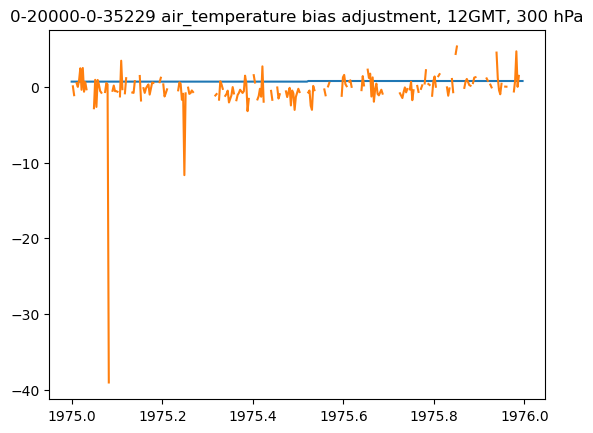

In [7]:
import matplotlib.pyplot as plt
import glob
print(os.getcwd())
pl=300
#fn=glob.glob(os.path.expandvars('$RSCRATCH/converted_v29/long/0-20000-0-35229*'))[0]
fn=glob.glob(os.path.expandvars('$RSCRATCH/converted_v29/long/'+wigos[0].decode()+'*'))[0]
with h5py.File(fn) as f:
    sl=slice(f['recordindices']['126'][:][0],f['recordindices']['126'][:][-1])
    idx=np.where((f['observations_table/z_coordinate'][sl]==pl*100))[0] #(wigos==b'0-20001-0-11035')&
    #print(idx)
    #vnu,vni=np.unique(vnames,return_inverse=True)
    print(vnu)
    ha=f["advanced_homogenisation/RASE_bias_estimate"][sl][idx]
    obs=f["observations_table/observation_value"][sl][idx]
    fg=f["era5fb/fg_depar@offline"][sl][idx]
    fg=f["era5fb/an_depar@body"][sl][idx]
    print('fg:',np.nanstd(fg))
    ts=f['observations_table/date_time'][sl][idx]
    ov=f['observations_table/observed_variable'][sl][idx]
    #print(vni.shape,vnu.shape,ts[0])
    print(ts.shape,idx.shape)
    l=1
    tstart=int((datetime(1975,1,1)-datetime(1900,1,1)).total_seconds())
    tend=int((datetime(1976,1,1)-datetime(1900,1,1)).total_seconds())
    for v in ['air_temperature']: #vnu[1:]:
#        #print(np.unique(vnames[idx]),f['report_timestamp'][:2])
        idy=np.where((ts>=tstart)&(ts<=tend)&(ts%86400>=40000)&(ts%86400<=45000)&(~np.isnan(obs)))[0]
        for i in idy[:10]:
            print(datetime(1900,1,1)+timedelta(seconds=int(ts[i])),ha[i],obs[i])
        idz=[]
        for t in tsh:
            idz.append(np.where(np.abs(ts[idy]-t)<7200)[0])
        print(len(idy),len(idz))
        if len(idz)>0:
            for ind in idz:
                print(datetime(1900,1,1)+timedelta(seconds=int(ts[idy[ind]])),ts[idy[ind]],obs[idy[ind]],ha[idy[ind]])
        #if len(idy)>0:
        #     print(f'{v} {idy[0]},{len(idy)},{np.sum(~np.isnan(ha[idy]))} {np.nanmean(ha[idy])} {np.nanstd(ha[idy])}')
        
        l+=1
        plt.plot(ts[idy]/86400/365.25+1900,ha[idy])
        plt.plot(ts[idy]/86400/365.25+1900,fg[idy])
        plt.title(wigos[0].decode()+f' {v} bias adjustment, 12GMT, {pl} hPa')
        plt.show()
        #idz=np.where(~np.isnan(ha[idy]))[0]
        #print(np.unique(wigos[idx[idy[idz]]]))
        #print(ha[idy[idz]])
        
        
    
    

In [8]:
import cdsapi

dataset = "insitu-comprehensive-upper-air-observation-network"
request = {
    "variable": [
        "air_dewpoint",
        "air_temperature",
        "dew_point_depression",
        "eastward_wind_speed",
        "geopotential_height",
        "northward_wind_speed",
        "relative_humidity",
        "specific_humidity",
        "wind_from_direction",
        "wind_speed"
    ],
    "year": ["1996"],
    "month": ["06"],
    "day": [
        "01", "02", "03",
        "04", "05", "06",
        "07", "08", "09",
        "10", "11", "12",
        "13", "14", "15",
        "16", "17", "18",
        "19", "20", "21",
        "22", "23", "24",
        "25", "26", "27",
        "28", "29", "30",
        "31"
    ],
    "data_format": "netcdf",
    "area": [80, -180, 30, 180]
}

target='new.nc'
client = cdsapi.Client()
client.retrieve(dataset, request,target)

2025-06-12 14:52:54,648 INFO [2025-06-10T00:00:00] To improve our C3S service, we need to hear from you! Please complete this very short [survey](https://confluence.ecmwf.int/x/E7uBEQ/). Thank you.
2025-06-12 14:52:54,648 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-06-12 14:52:55,177 INFO Request ID is 23fe9572-0b62-49ee-b4b4-4bea0a23c5c5
2025-06-12 14:52:55,318 INFO status has been updated to accepted
2025-06-12 14:52:56,461 INFO status has been updated to running
2025-06-12 14:52:58,073 INFO status has been updated to successful


d48dfe862487d5a5f2bca580caf75e23.nc:   0%|          | 0.00/228M [00:00<?, ?B/s]

'new.nc'

In [9]:
request = {
    "variable": [
        "air_dewpoint",
        "air_temperature",
        "dew_point_depression",
        "eastward_wind_speed",
        "geopotential_height",
        "northward_wind_speed",
        "relative_humidity",
        "specific_humidity",
        "wind_from_direction",
        "wind_speed"
    ],
    'year': [f'{m}' for m in range(1975,1976)],
    'month': [f'{m:0>2}' for m in range(1,2)],
    'day': ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31'],
    "data_format": "netcdf",
    "area": [90, -180, -90, 180]
}

target='newtsm.nc'
client.retrieve(dataset, request,target)

2025-06-12 14:53:24,508 INFO Request ID is 6e3d1b9f-07ad-4bc2-b98c-fbf9161256ab
2025-06-12 14:53:24,592 INFO status has been updated to accepted
2025-06-12 14:53:25,671 INFO status has been updated to running
2025-06-12 14:53:27,271 INFO status has been updated to successful


8efafe3aca2340893156173bdb86728.nc:   0%|          | 0.00/288M [00:00<?, ?B/s]

'newtsm.nc'

In [10]:
import matplotlib.pyplot as plt
print(os.getcwd())
pl=300
with h5py.File('newtsm.nc') as f:
    #print(f.keys())
    wigos=f['primary_station_id'][:].view(f'S{f['primary_station_id'].shape[1]}').flatten()
    z=f['z_coordinate'][:]
    vnames=(f['observed_variable'][:].view(f'S{f['observed_variable'].shape[1]}').flatten())
    print(np.unique(wigos))#,f['z_coordinate'][:100])
    print(vni.shape,vnu.shape)
    print(np.unique(wigos[idx]))
    l=1
    wu=np.unique(wigos)
    for w in wu:
        if b'26629' not in w:
            continue
        idx=np.where((z==pl*100)&(wigos==w))[0] #(wigos==b'0-20001-0-11035')&
        vname=vnames[idx]
        print(w)
        vnu=np.unique(vname)
        #print(vnu)
        ha=f["homogenisation_adjustment"][:][idx]
        obs=f["observation_value"][:][idx]
        ts=f["record_timestamp"][:][idx]
        for v in [b'specific_humidity']: #vnu[1:]:
    #        #print(np.unique(vnames[idx]),f['report_timestamp'][:2])
            idy=np.where((vname==v)&(ts%86400==43200)&(~np.isnan(obs)))[0]
            #if len(idy)>0:
                 #print(f'{v} {idy[0]},{len(idy)},{np.sum(~np.isnan(ha[idy]))} {np.nanmean(ha[idy])} {np.nanstd(ha[idy])}')
            l+=1
            if v==b'specific_humidity':
                idz=np.where(ha[idy]>0.1)[0]
                if len(idz)>0:
                    print(w,ha[idy[idz]],vname[idy[idz]],obs[idy[idz]])
            #plt.plot(ts[idy]/86400/365.25+1900,ha[idy])
            #plt.title(wigos[0].decode()+f' {v} bias adjustment, 12GMT, {pl} hPa')
            #plt.show()
        #idz=np.where(~np.isnan(ha[idy]))[0]
        #print(np.unique(wigos[idx[idy[idz]]]))
        #print(ha[idy[idz]])
        
        
    
    

/srvfs/home/leo/python/CEUAS/CEUAS/public/testing
[b'0-124-0-73033' b'0-152-0-320063' b'0-20000-0-01152' ...
 b'0-620-3001-08508' b'0-643-0-26708' b'0-724-0-0000000000008087']
(13795,) (10,)
[b'0-124-0-73033' b'0-20000-0-21982' b'0-20000-0-25399' b'0-20000-0-70026'
 b'0-20000-0-70086' b'0-20000-0-70133' b'0-20000-0-70200'
 b'0-20000-0-70219' b'0-20000-0-70231' b'0-20000-0-70261'
 b'0-20000-0-70266' b'0-20000-0-70273' b'0-20000-0-70308'
 b'0-20000-0-70316' b'0-20000-0-70326' b'0-20000-0-70350'
 b'0-20000-0-70361' b'0-20000-0-70398' b'0-20000-0-71036'
 b'0-20000-0-71069' b'0-20000-0-71074' b'0-20000-0-71119'
 b'0-20000-0-71120' b'0-20000-0-71123' b'0-20000-0-71199'
 b'0-20000-0-71267' b'0-20000-0-71467' b'0-20000-0-71514'
 b'0-20000-0-71585' b'0-20000-0-71608' b'0-20000-0-71689'
 b'0-20000-0-71693' b'0-20000-0-71849' b'0-20000-0-71853'
 b'0-20000-0-71863' b'0-20000-0-71869' b'0-20000-0-71877'
 b'0-20000-0-71892' b'0-20000-0-71908' b'0-20000-0-71989'
 b'0-20000-0-72235' b'0-20000-0-72240'

### CUON PUG v1.0
This notebook produces example plots for the Product User Guide of the Comprehensive Upper Air Network (CUON) dataset. It demonstrates
basic retrievals and interoperability with standard tools. It also demonstrates availability of advanced metadata, such as balloon drift or departures from the ERA5 global reanalysis.

The data can be fetched with a standard CDS retrieval, specifying date and area. Two formats can be chosen, netCDF and csv. NetCDF is recommended since it is faster and produces more compact files. The data come as single table, compliant with the CDM-OBS-Core convention. 

In [11]:
import cdsapi

dataset = "insitu-comprehensive-upper-air-observation-network"
request = {
    'variable': ['air_temperature', 'air_dewpoint','eastward_wind_speed','northward_wind_speed'],
    'year': ['2008'],
    'month': ['07'],
    'day': ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31'],
    'data_format': 'netcdf',
    'area': [50, 15, 45, 20],
}

nctarget='download.nc'
#client = cdsapi.Client()
client.retrieve(dataset, request, nctarget)

2025-06-12 14:54:01,282 INFO Request ID is cbb4d93d-d34b-40b8-b1af-ee8cd3370c30
2025-06-12 14:54:01,433 INFO status has been updated to accepted
2025-06-12 14:54:02,574 INFO status has been updated to running
2025-06-12 14:54:04,190 INFO status has been updated to successful


8c8d001ef0c1e627f9577adabdbace9.nc:   0%|          | 0.00/1.93M [00:00<?, ?B/s]

'download.nc'

Data can be read with xarray, then converted into a pandas dataframe. Strings come as byte strings, which are efficient, but most users may want to convert them into standard python strings. This is done in the loop below. The following cell lists the colums of the output data. 

In [6]:
import xarray as xr
import pandas as pd
import time
tt=time.time()
xa=xr.open_dataset(nctarget)   # getting an xarray is a oneliner
df=xa.to_dataframe()    # another oneline for a dataframe. 

# Note that strings are encoded in bytes for efficiency reasons. If the user wants strings, use the following loop.
print(df.observation_id[0])
for col, dtype in df.dtypes.items():
    if dtype == object:  # Only process byte object columns.
        df[col] = df[col].str.decode('utf-8')
print(df.observation_id[0])
# Units are given in CDM-OBS numbers, which is not convenient.
units={'5':'K','731':'m/s'}
print(time.time()-tt)

b'20080000000000218059'
20080000000000218059
0.30654144287109375


In [177]:
import h5py
import time
tt=time.time()
nctarget='download.nc'

with h5py.File(nctarget) as f:   # getting an xarray is a oneliner
    df={}
    index=f['index'].shape[0]
    for k in f.keys():
        if f[k].shape[0]!=index:
            continue
        #print(k,f[k].shape,end=' ')
        if f[k].ndim==2:
            df[k]=f[k][:].view(f'S{f[k].shape[1]}').astype(str).ravel()
            #print(k,f[k].shape,df[k].shape,end=' ')
            #du=df[k].astype(str).flatten()
            #print(du[0])
        else:
            df[k]=f[k][:]
    for d,v in df.items():
        print(d,v[0],type(d[0]))
    df=pd.DataFrame(df)
    print('h5py:',time.time()-tt)
units={'5':'K','731':'m/s'}


an_depar@body -0.5550683 <class 'str'>
city Schwechat,Tulln,Vienna <class 'str'>
data_policy_licence 0 <class 'str'>
fg_depar@body -0.76284957 <class 'str'>
fg_depar@offline nan <class 'str'>
height_of_station_above_sea_level 152.8 <class 'str'>
homogenisation_adjustment -0.0 <class 'str'>
homogenisation_method 14 <class 'str'>
index 0.0 <class 'str'>
latitude 48.079857 <class 'str'>
latitude|header_table 48.25 <class 'str'>
longitude 16.625673 <class 'str'>
longitude|header_table 16.37 <class 'str'>
observation_id 20080000000000218059 <class 'str'>
observation_value -14.942921 <class 'str'>
observed_variable eastward_wind_speed <class 'str'>
platform_type 0 <class 'str'>
primary_station_id 0-20001-0-11035 <class 'str'>
profile_id 20080000000000000724 <class 'str'>
quality_flag 2 <class 'str'>
record_timestamp 3423880800 <class 'str'>
report_duration -2147483648 <class 'str'>
report_id 20080000000000000724 <class 'str'>
report_meaning_of_timestamp 1 <class 'str'>
report_timestamp 34238

In [178]:
print('size:',os.path.getsize(nctarget)//1024,'kB')
idx=np.where(df['z_coordinate'].values==50000.)[0][0]
for d in df.columns:
    if d in ['report_type','report_duration','station_type','secondary_id']:
        continue
    if 'units' in d:
        print(f'{d: >35}\t{units[df[d][idx]]}')
    else:
        print(f'{d: >35}\t{df[d][idx]}')

size: 1977 kB
                      an_depar@body	-0.5716570615768433
                               city	Schwechat,Tulln,Vienna
                data_policy_licence	0
                      fg_depar@body	-1.11552894115448
                   fg_depar@offline	-1.0720129013061523
  height_of_station_above_sea_level	152.8000030517578
          homogenisation_adjustment	-0.0
              homogenisation_method	14
                              index	0.0
                           latitude	48.229591369628906
              latitude|header_table	48.25
                          longitude	16.402366638183594
             longitude|header_table	16.3700008392334
                     observation_id	20080000000000218158
                  observation_value	5.437846660614014
                  observed_variable	eastward_wind_speed
                      platform_type	0
                 primary_station_id	0-20001-0-11035
                         profile_id	20080000000000000724
                       quality

Zipped csv files are the alternative to netCDF. They need significantly more space but can be read directly into spreadsheets or into pandas
There is also no need to convert strings. When reading the CSV, the header lines in the beginning must be considered. 

In [179]:
dataset = "insitu-comprehensive-upper-air-observation-network"
request = {
    'variable': ['air_temperature', 'air_dewpoint','eastward_wind_speed','northward_wind_speed'],
    'year': ['2010'],
    'month': ['07'],
    'day': ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31'],
    'format': 'csv',
    'area': [50, 15, 45, 20],
}

target='download.zip'
client = cdsapi.Client()
client.retrieve(dataset, request, target)

2025-06-16 11:02:11,692 INFO [2025-06-10T00:00:00] To improve our C3S service, we need to hear from you! Please complete this very short [survey](https://confluence.ecmwf.int/x/E7uBEQ/). Thank you.
2025-06-16 11:02:11,693 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-06-16 11:02:12,575 INFO Request ID is 96f79c2d-d792-48b0-a8f3-d8c7922fdad8
2025-06-16 11:02:12,655 INFO status has been updated to accepted
2025-06-16 11:02:13,751 INFO status has been updated to successful


78d277ff6a948e04e880ebd8891d6c2b.zip:   0%|          | 0.00/28.6M [00:00<?, ?B/s]

'download.zip'

In [180]:
import zipfile
with zipfile.ZipFile(target) as z:
    for n in z.namelist():
        with z.open(n) as f:
            l=-1
            h=next(f).decode()
            while len(h)<2 or '#' in h:
                print(h,end='')
                h=next(f).decode()
                l+=1  			
print(l)
df=pd.read_csv(target,header=l)


########################################################################################
# This file contains data retrieved from the CDS https://cds.climate.copernicus.eu/cdsapp#!/dataset/insitu-comprehensive-upper-air-observation-network
# This is a C3S product under the following licences:
# 20180314_Copernicus_License_V1.1
# This is a CSV file following the CDS convention cdm-obs
# Data source: CUON
# Time extent: 20100701 - 20100731
# Geographic area (minlat/maxlat/minlon/maxlon): 45.17/49.92/15.19/19.87
# Variables selected and units:
# air_temperature [5]
# air_dewpoint [5]
# eastward_wind_speed [731]
# northward_wind_speed [731]
# Uncertainty legend:
# uncertainty_value1 Random uncertainty
########################################################################################
16


In [181]:
df

,index,observation_id,report_id,data_policy_licence,z_coordinate,z_coordinate_type,observed_variable,observation_value,units,sensor_id,...,an_depar@body,fg_depar@body,fg_depar@offline,uncertainty_type1,uncertainty_units1,uncertainty_value1,longitude,latitude,longitude|header_table,latitude|header_table
0,0,20100000000000060865,20100000000000000176,0,4410.0,1,air_temperature,219.100000,5,79,...,-0.193398,-0.445539,NaN,1,5,NaN,15.556254,46.903220,15.43,47.00
1,1,20109900000000062765,20100000000000000176,0,4660.0,1,air_temperature,219.451320,5,79,...,0.318637,0.141964,NaN,1,5,NaN,15.556254,46.903220,15.43,47.00
2,2,20109900000000062766,20100000000000000176,0,4880.0,1,air_temperature,219.745220,5,79,...,0.747001,0.633466,NaN,1,5,NaN,15.555179,46.904144,15.43,47.00
3,3,20100000000000060882,20100000000000000176,0,5000.0,1,air_temperature,219.900000,5,79,...,0.972577,0.892289,0.988632,1,5,0.560086,15.555072,46.903732,15.43,47.00
4,4,20100000000000060891,20100000000000000176,0,5970.0,1,air_temperature,221.300000,5,79,...,2.725398,3.562392,NaN,1,5,NaN,15.562116,46.898500,15.43,47.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91855,91855,20109900000000344862,20100000000000000850,0,90100.0,1,northward_wind_speed,-3.908344,731,VnG,...,1.107061,0.407264,NaN,1,731,NaN,16.374775,48.246002,16.37,48.25
91856,91856,20100000000000264684,20100000000000000850,0,92500.0,1,northward_wind_speed,-3.276608,731,VnG,...,0.425285,0.276508,0.144919,1,731,1.216656,16.373285,48.247420,16.37,48.25
91857,91857,20109900000000344863,20100000000000000850,0,98000.0,1,northward_wind_speed,-1.655451,731,VnG,...,-0.666714,-0.354516,NaN,1,731,NaN,16.370607,48.249638,16.37,48.25
91858,91858,20109900000000344864,20100000000000000850,0,98500.0,1,northward_wind_speed,-1.512592,731,VnG,...,-0.762943,-0.410123,NaN,1,731,NaN,16.370413,48.249760,16.37,48.25


In [182]:
print('size:',os.path.getsize(target)//1024,'kB')
for d in df.columns:
    print(f'{d: >35}\t{df[d][0]}')

size: 29323 kB
                              index	0
                     observation_id	20100000000000060865
                          report_id	20100000000000000176
                data_policy_licence	0
                       z_coordinate	4410.0
                  z_coordinate_type	1
                  observed_variable	air_temperature
                  observation_value	219.1
                              units	5
                          sensor_id	79
                          source_id	era5_1
                        report_type	-2147483648
                       station_name	GRAZ-THALERHOF-FLUGHAFEN
                       station_type	1
                      platform_type	0
                 primary_station_id	0-20000-0-11240
  height_of_station_above_sea_level	378.8
                   report_timestamp	2010-07-01 02:30:00
                    report_duration	-2147483648
                   record_timestamp	2010-07-01 03:00:00
                       secondary_id	11239,11240,11241,5682,AU

Many users may want a single station ID. Since the data are selected by area, there is always a chance that data from other than desired station are in the output file as well. The found identifiers can be listed with the code below. 

In [183]:
import numpy as np
print(np.unique(df['primary_station_id']))


['0-20000-0-11240' '0-20000-0-11747' '0-20000-0-12843' '0-20000-0-14240'
 '0-20001-0-11035']


Som users like SQL type queries. Pandas dataframes can be queried using duckdb. An example is given below. An equivalent query using pandas syntay follows

In [184]:
import duckdb
import datetime
print(duckdb.query(f"select observed_variable,observation_value from df \
where record_timestamp=='2010-07-01 12:00:00' \
and primary_station_id=='0-20001-0-11035' \
and z_coordinate==50000"))

┌──────────────────────┬───────────────────┐
│  observed_variable   │ observation_value │
│       varchar        │      double       │
├──────────────────────┼───────────────────┤
│ air_temperature      │             258.9 │
│ air_dewpoint         │             235.9 │
│ eastward_wind_speed  │         5.7850885 │
│ northward_wind_speed │           -6.8944 │
└──────────────────────┴───────────────────┘



In [185]:
df[(df.record_timestamp=='2010-07-01 12:00:00') & 
    (df.primary_station_id=='0-20001-0-11035') &
    (df.z_coordinate==50000)].filter(['primary_station_id','z_coordinate',
                                      'observed_variable','observation_value'])

,primary_station_id,z_coordinate,observed_variable,observation_value
1012,0-20001-0-11035,50000.0,air_temperature,258.900000
1069,0-20001-0-11035,50000.0,air_dewpoint,235.900000
1162,0-20001-0-11035,50000.0,eastward_wind_speed,5.785088
1255,0-20001-0-11035,50000.0,northward_wind_speed,-6.894400


A basic t-logp plot of a single ascent can be created with the following code

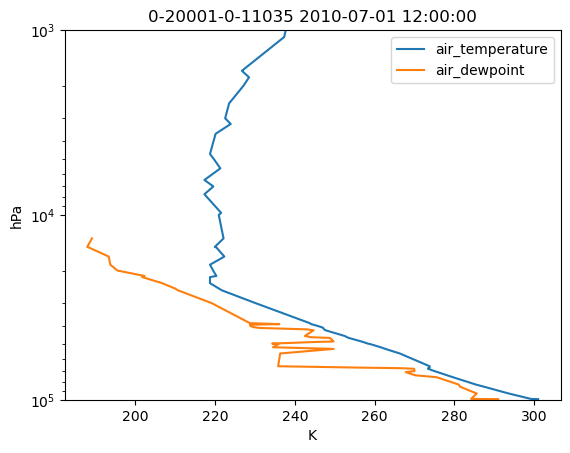

In [186]:
tstamp='2010-07-01 12:00:00'
sid='0-20001-0-11035'
tlogp=df[(df.record_timestamp==tstamp) & (df.primary_station_id==sid)].\
filter(['z_coordinate','observed_variable','observation_value'])
%matplotlib inline
import matplotlib.pyplot as plt
for p in 'air_temperature','air_dewpoint':
    plt.semilogy(tlogp.observation_value[df.observed_variable==p],tlogp.z_coordinate[df.observed_variable==p],label=p)
plt.ylim(100000,1000)
plt.ylabel('hPa')
plt.xlabel('K')
plt.title(f'{sid} {tstamp}')
plt.legend()

Users may want to use standard meteorological packages such as metpy for fancier plots of radiosonde ascents. The cell below demonstrates
interoperability with this package. 

There is one challenge: CUON uses a ragged array format, metpy needs aligned data, so we need to fill with NaNs.

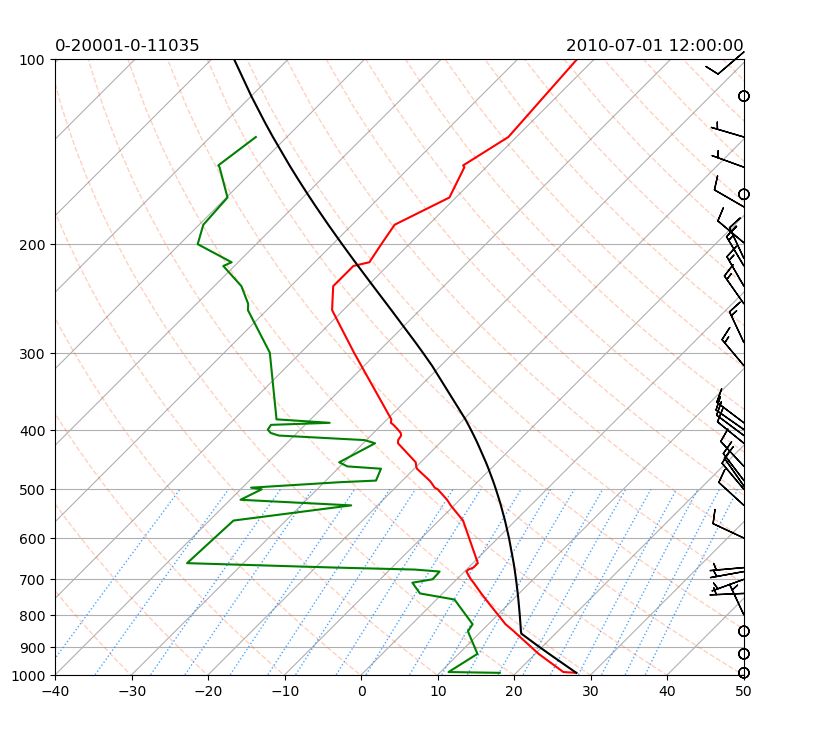

In [187]:
import metpy.calc as mpcalc
from metpy.cbook import get_test_data
from metpy.plots import add_metpy_logo, SkewT
from metpy.units import units

p = tlogp.z_coordinate[df.observed_variable=='air_temperature'].values[::-1]/100 * units.hPa
T = (tlogp.observation_value[df.observed_variable=='air_temperature'].values[::-1]-273.15) * units.degC
u = (tlogp.observation_value[df.observed_variable=='eastward_wind_speed'].values[::-1]) * units.ms
v = (tlogp.observation_value[df.observed_variable=='northward_wind_speed'].values[::-1]) * units.ms
pu = tlogp.z_coordinate[df.observed_variable=='eastward_wind_speed'].values[::-1]/100 * units.hPa
pdew= (tlogp.z_coordinate[df.observed_variable=='air_dewpoint'].values[::-1])/100 * units.hPa
ppd=p[:]
mask=np.isin(p,pdew)
Td=T.copy()
Td[mask] = (tlogp.observation_value[df.observed_variable=='air_dewpoint'].values[::-1]-273.15) * units.degC
Td[~mask]=np.nan

ds = mpcalc.parcel_profile_with_lcl_as_dataset(p, T, Td)
fig = plt.figure(figsize=(10, 8))
skew = SkewT(fig, rotation=45)

# Plot the data using the data from the xarray Dataset including the parcel temperature with
# the LCL level included
skew.plot(ds.isobaric, ds.ambient_temperature, 'r')
skew.plot(ds.isobaric, ds.ambient_dew_point, 'g')
skew.plot(ds.isobaric, ds.parcel_temperature.metpy.convert_units('degC'), 'black')

# Plot the wind barbs from the original data
skew.plot_barbs(pu[::2], u[::2], v[::2])

# Add the relevant special lines
pressure = np.arange(1000, 499, -50) * units('hPa')
mixing_ratio = np.array([0.1, 0.2, 0.4, 0.6, 1, 1.5, 2, 3, 4,
                        6, 8, 10, 13, 16, 20, 25, 30, 36, 42]).reshape(-1, 1) * units('g/kg')

skew.plot_dry_adiabats(t0=np.arange(233, 533, 10) * units.K, alpha=0.25,
                       colors='orangered', linewidths=1)
skew.plot_mixing_lines(pressure=pressure, mixing_ratio=mixing_ratio, linestyles='dotted',
                       colors='dodgerblue', linewidths=1)
skew.ax.set_ylim(1000, 100)

# Add some titles
plt.title(sid, loc='left')
plt.title(tstamp, loc='right')

plt.show()

Time series analysis is of course also supported. There may be faster platforms to retrieve time series data, but CUON provides unique additional metadata that help assessing observation quality and also help reduce representation errors. 

In [116]:
request = {
    'variable': ['air_temperature', 'air_dewpoint'],
    'year': [f'{m}' for m in range(1980,1983)],
    'month': [f'{m:0>2}' for m in range(1,13)],
    'day': ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31'],
    'format': 'netcdf',
    'area': [50, 15, 45, 20],
}

tstarget='tsdownload.nc'
client.retrieve(dataset, request, tstarget)

2025-06-11 09:37:15,208 INFO Request ID is 03056303-687e-49b3-89bd-a58bdf809e30
2025-06-11 09:37:15,375 INFO status has been updated to accepted
2025-06-11 09:37:16,564 INFO status has been updated to running
2025-06-11 09:37:18,162 INFO status has been updated to successful


8156a66b2e8d6f72443bd31241a85e16.nc:   0%|          | 0.00/12.5M [00:00<?, ?B/s]

'tsdownload.nc'

Again, pandas can be used to filter the desired data. Note that a time interval is used to distinguish between daytime and nighttime ascents.

Instead of quality flags, CUON relies on departure from reanalysis data for quality assessments. Particularly in more recent times, the reanalysis quality is high enough to single out observations that need attention. They show up as data with large analysis or background errors. An example time series of the available departures is given. fg_depar@body and an_depar@body is the departure of a bias adjusted observation from the ERA5 background forecast and analysis, respectively. 
fg_depar@offline is the background departure, calculated a posteriori using the available gridded forecast data on pressure levels. This departure has larger interpolation errors, both in time and in space, but it is calculated taking the balloon drift into account. In case of strong drifts, fg_depar@offline tends to be smaller than fg_depar@body. 

xarray: 0.8610310554504395
[-7.03661804 54.33052324]


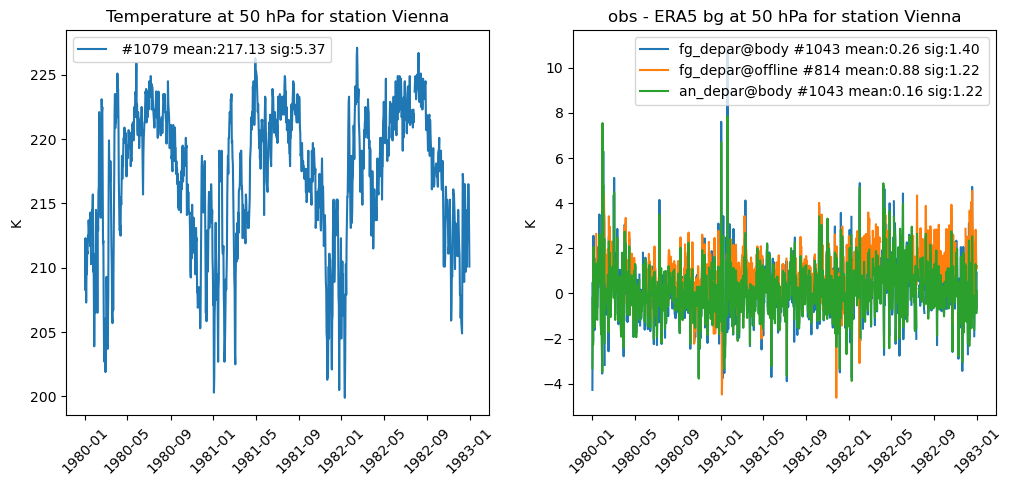

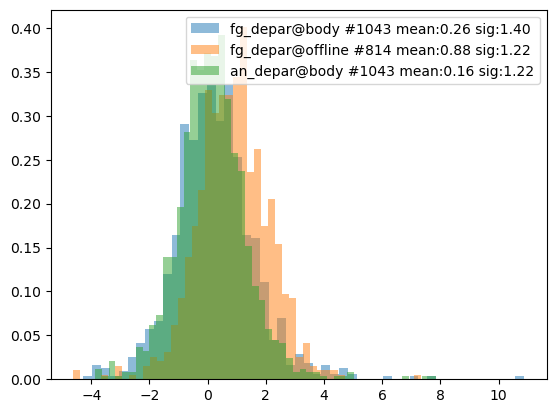

In [117]:
import time
tt=time.time()
pl=50
df=xr.open_dataset(tstarget).to_dataframe()
print('xarray:',time.time()-tt)
ts=df[(df.primary_station_id==b'0-20001-0-11035')&
    (df.observed_variable==b'air_temperature')& (df.z_coordinate==100*pl)&
    (df.report_timestamp.dt.hour.values>=10)&(df.report_timestamp.dt.hour.values<=14)]#.\

plt.figure(figsize=(12,5))
ax=plt.subplot(1,2,1)
andv=ts['an_depar@body'].values
q=np.nanquantile(andv,(0.001,0.999))
print(q)
mask=(andv<q[0])|(andv>q[1])
obs=ts.observation_value.values
obs[mask]=np.nan
plt.plot(ts.record_timestamp,obs,label=f' #{np.sum(~np.isnan(obs))} mean:{np.nanmean(obs):.2f} sig:{np.nanstd(obs):.2f}')
plt.ylabel('K')
plt.legend()
plt.title(f'Temperature at {pl} hPa for station Vienna')
ax.tick_params(axis='x', labelrotation=45)

ax=plt.subplot(1,2,2)
for fb in 'fg_depar@body','fg_depar@offline','an_depar@body',:
    ts[fb].values[mask]=np.nan
    plt.plot(ts.record_timestamp.values,ts[fb],label=f'{fb} #{np.sum(~np.isnan(ts[fb]))} mean:{np.nanmean(ts[fb]):.2f} sig:{np.nanstd(ts[fb]):.2f}')
plt.ylabel('K')
plt.legend()
plt.title(f'obs - ERA5 bg at {pl} hPa for station Vienna')
ax.tick_params(axis='x', labelrotation=45)
plt.figure()
for fb in 'fg_depar@body','fg_depar@offline','an_depar@body',:
    plt.hist(ts[fb],alpha=0.5,density=True,bins=50,label=f'{fb} #{np.sum(~np.isnan(ts[fb]))} mean:{np.nanmean(ts[fb]):.2f} sig:{np.nanstd(ts[fb]):.2f}')
plt.legend()

The plot below shows balloon positions encountered at radiosonde station Vienna, using all available pressure levels(red) and at the 300 hPa level (yellow).
In this example h5py was chosen for reading the downloaded netCDF file and to convert to a dataframe only what is needed. It is several times faster than using xarray.

In [118]:
import h5py
import cartopy.crs as ccrs
import cartopy.feature as cfeature
tt=time.time()
with h5py.File(tstarget) as f:
    d={}
    for k in ('primary_station_id',
              'z_coordinate','longitude','latitude'):
        if f[k].ndim==2:
            d[k]=f[k][:].view(f'S{f[k].shape[1]}').flatten()
        else:
            d[k]=f[k][:]
    df=pd.DataFrame(d)
print('h5py:',time.time()-tt)


h5py: 0.18656539916992188


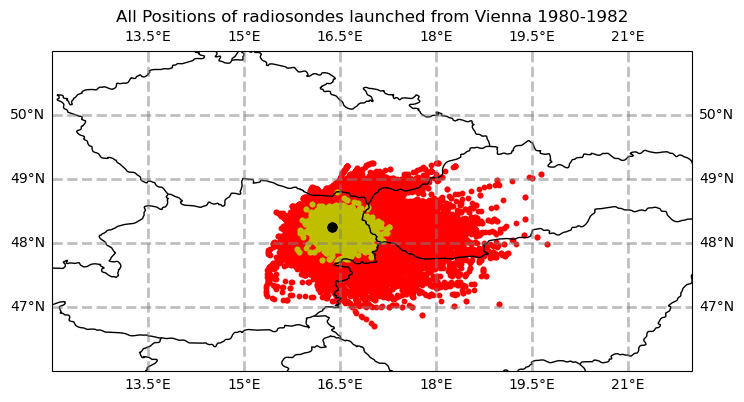

In [120]:
df=xr.open_dataset(tstarget).to_dataframe()

ax = plt.axes([0, 0, 1, 1], projection=ccrs.PlateCarree())
ax.set_extent([12,22,46,51])
ax.add_feature(cfeature.OCEAN, zorder=0)
ax.add_feature(cfeature.BORDERS, linestyle='-', alpha=1)
ax.coastlines()
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')

idx=np.where(df['primary_station_id']==b'0-20001-0-11035')[0]
idy=np.where(df['z_coordinate'][idx]==30000)[0]
plt.scatter(df['longitude'].values[idx], df['latitude'].values[idx], s=10, alpha=1,
                color='r',)
plt.scatter(df['longitude'].values[idx[idy]], df['latitude'].values[idx[idy]], s=10, alpha=1,
                color='y',)
plt.scatter(df['longitude'].values[idx][-2:], df['latitude'].values[idx][-2:], s=40, alpha=1,
                color='k',)
x=plt.title('All Positions of radiosondes launched from Vienna 1980-1982')

#plt.figure(figsize=(10,4))
#idy=np.where(df['z_coordinate'][idx]==15000)[0]

#plt.hist(df['longitude'].values[idx[idy]],bins=50,density=True)
#x=plt.title('longitude distribution at 150 hPa')



CUON also contains station metadata. This can be useful to analyse the performance or the impact of certain sensors. Here we just plot which stations use a certain radiosonde type (Vaisala RS41) at least once in a particular month.

In [19]:
request = {
    'variable': ['air_temperature', 'air_dewpoint'],
    'year': ['2024'],
    'month': ['12'],
    'day': ['01'],
    'format': 'netcdf',
}

mtarget='download1.nc'
client.retrieve(dataset, request, mtarget)

2025-06-04 09:47:31,083 INFO Request ID is 75c1927d-4316-49b1-aa83-229d6a4241b1
2025-06-04 09:47:31,283 INFO status has been updated to accepted
2025-06-04 09:47:32,396 INFO status has been updated to running
2025-06-04 09:47:36,404 INFO status has been updated to successful
                                                                                                                       

'download1.nc'

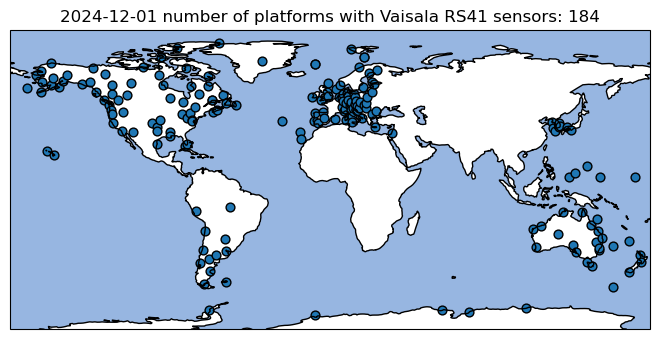

In [20]:
df=xr.open_dataset(mtarget).to_dataframe()
ax = plt.axes([0, 0, 1, 1], projection=ccrs.PlateCarree())
ax.add_feature(cfeature.OCEAN, zorder=0)
ax.coastlines()
_,idx=np.unique(df['longitude|header_table'],return_index=True)
idy=np.where(np.isin(df['sensor_id'][idx] ,(b'123',b'124',b'125',b'141',b'142')))[0]
longitudes = list(df['longitude|header_table'][idx[idy]])
latitudes = list(df['latitude|header_table'][idx[idy]])
plt.scatter(longitudes, latitudes, s=40, alpha=1,
                edgecolor='k',)
x=plt.title('2024-12-01 number of platforms with Vaisala RS41 sensors: '+str(len(idy)))



In [65]:
request = {
    "variable": [
        "air_dewpoint",
        "air_temperature",
         "dew_point_depression",
        "eastward_wind_speed",
        "geopotential_height",
        "northward_wind_speed",
        "relative_humidity",
        "specific_humidity",
        "wind_from_direction",
        "wind_speed"
   ],
    'year': [f'{m}' for m in range(1993,1998)],
    'month': [f'{m:0>2}' for m in range(1,13)],
    'day': ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31'],
    "data_format": "netcdf",
    "area": [8,134,7,135]
}
# [49, 15, 48, 18] Vienna
# [36,-98,35,-97] Norman, OK
# [8,134,7,135] Koror, US Pac
target='newts.nc'
client.retrieve(dataset, request,target)

2025-06-10 11:54:51,375 INFO Request ID is 46e6f1e1-069e-44aa-98c8-d7723b532700
2025-06-10 11:54:51,447 INFO status has been updated to accepted
2025-06-10 11:54:52,542 INFO status has been updated to running
2025-06-10 12:01:10,942 INFO status has been updated to successful


a2a8441f294561ad2d823e7cdd144f95.nc:   0%|          | 0.00/55.2M [00:00<?, ?B/s]

'newts.nc'

[b'0-20000-0-91408']
b'air_temperature' 15,1662,1467 0.2439556121826172


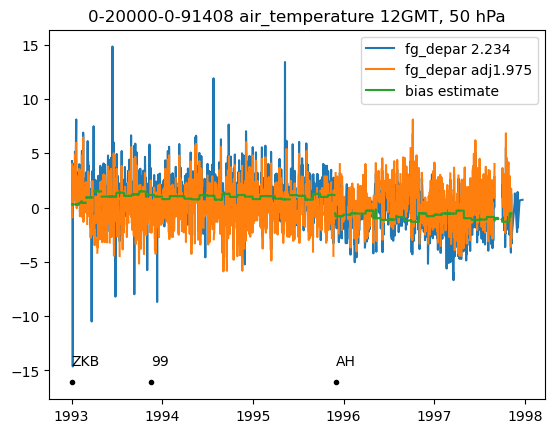

In [111]:
import h5py
import numpy as np
pl={b'air_temperature':50,b'relative_humidity':200}
with h5py.File('newts.nc') as f:
    wigos=f['primary_station_id'][:].view(f'S{f['primary_station_id'].shape[1]}').flatten()
    print(np.unique(wigos))
    vnames=(f['observed_variable'][:].view(f'S{f['observed_variable'].shape[1]}').flatten())
    for v in [b'air_temperature']: #,b'relative_humidity']:
        idx=np.where((f['z_coordinate'][:]==pl[v]*100))[0] #(wigos==b'0-20001-0-11035')&

        ha=f["homogenisation_adjustment"][:][idx]
        ha[ha==0]=np.nan
        fb=f["fg_depar@offline"][:][idx]
        ts=f["record_timestamp"][:][idx]
        obs=f['observation_value'][:][idx]
        rt,rti=np.unique(f['sensor_id'][:].view(f'S{f['sensor_id'].shape[1]}').flatten()[idx],return_index=True)

        idy=np.where((~np.isnan(obs))&(vnames[idx]==v)&((ts%86400<40000)|(ts%86400>45000)))[0]
        if len(idy)>0:
            print(f'{v} {idy[0]},{len(idy)},{np.sum(~np.isnan(ha[idy]))} {np.nanmean(ha[idy])}')
            plt.plot(ts[idy]/86400/365.25+1900,fb[idy],label=f'fg_depar {np.nanstd(fb[idy]):.3f}')
            plt.plot(ts[idy]/86400/365.25+1900,fb[idy]-ha[idy],label=f'fg_depar adj{np.nanstd(fb[idy]-ha[idy]):.3f}')
            plt.plot(ts[idy]/86400/365.25+1900,ha[idy],label='bias estimate')
            lyb=plt.gca().get_ybound()
            rtis=np.argsort(ts[rti])

            for ll in range(len(rti)):
                #if ll<len(rti)-1 : print(ts[rti][rtis][ll+1]-ts[rti][rtis][ll])
                if ll<len(rti)-1 and (ts[rti][rtis][ll+1]-ts[rti][rtis][ll])<0.3*365*86400:
                    continue
                    
                plt.scatter(ts[rti][rtis][ll]/86400/365.25+1900,lyb[0],marker='.',color='k')
                plt.text(ts[rti][rtis][ll]/86400/365.25+1900,lyb[0]+0.05*(lyb[1]-lyb[0]),rt[rtis][ll].decode())

            plt.title(wigos[0].decode()+f' {v.decode()} 12GMT, {pl[v]} hPa')
            plt.legend()
            plt.show()
